In [1]:
%%configure -f
{ "conf":{
          "spark.pyspark.python": "python3",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv",
          "spark.sql.execution.arrow.enabled":"true"
         }
}

[I 2023-03-10 20:44:24,279.279 configure_magic] Magic cell payload received: {"conf": {"spark.pyspark.python": "python3", "spark.pyspark.virtualenv.enabled": "true", "spark.pyspark.virtualenv.type": "native", "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv", "spark.sql.execution.arrow.enabled": "true"}, "proxyUser": "assumed-role_fdp_blitvin-Isengard"}

[I 2023-03-10 20:44:24,279.279 configure_magic] Sending request to update kernel. Please wait while the kernel will be refreshed.


The kernel is successfully refreshed.

In [1]:
import pyEX as p
import requests
import json
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools
import datetime
#import awswrangler as wr
import vectorbt as vbt
import pyspark.sql.functions as py_f
import pyspark.sql.types as py_t
import pyspark.sql.window as py_w
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.requests import StockBarsRequest
import pyarrow as pa
import pyarrow.parquet as pq
import boto3
from botocore.exceptions import ClientError
import pyfolio as pf
import scipy.stats as stats
from numba import jit

/usr/local/lib/python3.7/site-packages/tzlocal/unix.py:177: UserWarning: Can not find any timezone configuration, defaulting to UTC.
  warnings.warn("Can not find any timezone configuration, defaulting to UTC.")
/usr/local/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [4]:
#@py_f.pandas_udf("date timestamp, close double, open double, symbol string", py_f.PandasUDFType.GROUPED_MAP)
#@py_f.pandas_udf("symbol string", py_f.PandasUDFType.GROUPED_MAP)
#syms=pd.DataFrame([{'symbol':'SPY'}])
#get_new_data_df(syms)
def get_new_data_df(symbol):
    local_sym = str(symbol.values[0][0])
    try:
        hwm_l = highwatermark_pd_bc.value
        columns_to_capture = columns_to_capture_bc.value
        iex_base_url = iex_base_url_bc.value
        sym_pd = hwm_l.query(f"symbol=='{local_sym}'")
        if len(sym_pd) > 0:
            max_date = sym_pd['max_date'].iloc[0]
        else:
            max_date = datetime.datetime.now() - datetime.timedelta(days=365 *
                                                                    50)
        last_days = (datetime.datetime.now() - max_date).days

        pyEX_cl = p.Client(api_token=iex_token_bc.value)
        final_url = iex_base_url.format(local_sym, iex_token_bc.value,
                                        int(last_days))
        #'https://cloud.iexapis.com/stable/stock/{}/chart/max?token={}&chartIEXOnly=true&chartLast={}'
        print(final_url)
        res = requests.get(final_url)
        ret_pd = pd.DataFrame(json.loads(res.text))  #[columns_to_capture]
        ret_pd = ret_pd.query(f"date>'{max_date.strftime('%Y-%m-%d')}'")
        ret_pd['date'] = pd.to_datetime(ret_pd['date'])
        ret_pd['symbol'] = local_sym
        for one_col in ['open', 'high', 'low', 'close']:
            ret_pd[f'market{one_col.capitalize()}'] = np.where(
                ret_pd[f'market{one_col.capitalize()}'].isnull(),
                ret_pd[one_col], ret_pd[f'market{one_col.capitalize()}'])
            ret_pd[one_col] = np.where(ret_pd[one_col].isnull(),
                                       ret_pd[f'market{one_col.capitalize()}'],
                                       ret_pd[one_col])
        #return(ret_pd[columns_to_capture].query(f"date>'{max_date}'"))
    except:
        ret_pd = pd.DataFrame([{
            'date': datetime.datetime.now() - datetime.timedelta(days=365 * 50),
            'minute': None,
            'open': None,
            'high': None,
            'low': None,
            'close': None,
            'notional': None,
            'numberOfTrades': None,
            'symbol': local_sym,
            'marketOpen': None,
            'marketHigh': None,
            'marketLow': None,
            'marketClose': None,
            'marketNotional': None,
            'marketNumberOfTrades': None
        }])
    #return(ret_pd[columns_to_capture],max_date,hwm_l,local_sym,sym_pd)
    return (ret_pd[columns_to_capture])
    #return(pd.DataFrame([res.text],columns=['symbol']))

In [ ]:
refresh_data = True
timeframe=1

class MarketDataGateway():
    def __init__(self, tf,isSandbox=False,shard_size=20):
        self.shard_size=shard_size
        self.fx_etf_symbols = [
            'FXA',
            'FXY',
            'FXE',
            'FXB',
            'UUP',
            'FXC',
            'FXF',
        ]
        self.bitcoin_etf_symbols = [
            'BITO', 'BTF', 'XBTF', 'BITS', 'GBTC', 'BITW', 'BLOK', 'BLCN',
            'LEGR', 'SPBC', 'BITQ', 'BKCH', 'DAPP', 'BTCFX'
        ]
        self.bitcoin_equity_proxy_symbols = ['COIN', 'MSTR']
        self.crypto_mining_symbols = [
            'RIOT', 'CAN', 'HUT', 'HIVE', 'MARA', 'BTCM', 'BTBT', 'BITF'
        ]
        self.commod_etf_symbols = [
            'USO',
            'GLD',
            'DBA',
            'DBB',
            'SLV',
        ]
        self.fi_etf_symbols = [
            'IAGG',
            'AGG',
            'IHY',
            'EMLC',
            'HYG',
        ]
        self.equity_share_class_pairs = ['GOOG','GOOGL',
'AMC','APE',
'BRK.A','BRK.B',
'CWEN','CWEN.A',
'CRD.A','CRD.B',
'FCNCA','FCNCO',
'F','F/PC',
'GTN','GTN.A',
'GEF','GEF.B',
'GR3','GB6B',
'HLAH','HLAHU',
'HEI','HEI.A',
'WLY','WLYB',
'2F7','2F70',
'KELYA','KELYB',
'LEN','LEN.B',
'LBRDK','LBRDA',
'8L8C','8L8',
'QRTEA','QRTEB',
'LSXMA','LSXMK',
'FWONA','FWONK',
'BATRA','BATRK',
'LTRPA','LTRPB',
'MKC','MKC.V',
'MKC','MKCV',
'MSTR','MSTRD',
'TAP','TAP.A',
'TPX.A','TPX.B',
'MOG.A','MOG.B',
'MO7A','MO7R',
'NWS','NWSA',
'PICC','PICC.U',
'RDI','RDIB',
'RUSHA','RUSHB',
'SENEA','SENEB',
'MSGE','MSGS',
'T2E','4T0',
'FOX','FOXA',
'UA','UAA',
'UBA','UBP',
'0VV','0VVB',
'WSO','WSO.B',
        ]
        self.equity_etf_symbols = [
            'AMJ', 'AMLP', 'ARKF', 'ARKG', 'ARKK', 'ARKQ', 'ARKW', 'BOTZ',
            'BUG', 'CGW', 'CIBR', 'COPX', 'CRBN', 'DRIV', 'EFV', 'EMLP', 'FBT',
            'FDN', 'FIVG', 'FIW', 'FTXG', 'GDX', 'GNR', 'GUNR', 'HACK', 'IAT',
            'IBB', 'ICLN', 'IEO', 'IFRA', 'IGE', 'IGF', 'IGM', 'IGV', 'IHF',
            'IHI', 'ITB', 'ITZ', 'IWD', 'IWN', 'IWS', 'IYT', 'JETS', 'KBWB',
            'KOMP', 'KRE', 'KWEB', 'LCTU', 'LIT', 'MLPA', 'MLPX', 'MOO', 'NFRA',
            'OIH', 'PABU', 'PAVE', 'PBW', 'PEJ', 'PHO', 'PICK', 'PPA', 'QCLN',
            'REET', 'REMX', 'ROBO', 'SCHH', 'SIL', 'SKYY', 'SMH', 'SOXX',
            'SRVR', 'TAN', 'URA', 'URNM', 'VUG', 'XAR', 'XBI', 'XHB', 'XME',
            'XOP', 'XSD', 'QQQ', 'EWZ', 'AAXJ', 'VTI', 'EWJ', 'EWA', 'EWC',
            'MCHI', 'EWU', 'EWQ', 'EWG', 'FM', 'EIS'
        ]
        self.sectors = [
            'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE',
            'XLK', 'XLU'
        ]
        self.sp500 = [
            "AAPL", "MSFT", "AMZN", "GOOGL", "BRK.B", "GOOG", "NVDA", "TSLA",
            "XOM", "UNH", "JNJ", "JPM", "V", "META", "PG", "HD", "CVX", "MA",
            "LLY", "MRK", "ABBV", "BAC", "PFE", "AVGO", "KO", "PEP", "TMO",
            "COST", "WMT", "DIS", "MCD", "CSCO", "ABT", "WFC", "ACN", "DHR",
            "ADBE", "CMCSA", "VZ", "CRM", "PM", "NKE", "NFLX", "LIN", "TXN",
            "COP", "BMY", "NEE", "QCOM", "RTX", "T", "HON", "CAT", "ORCL",
            "AMGN", "UPS", "MS", "LOW", "SBUX", "UNP", "SPGI", "IBM", "AMD",
            "GS", "PLD", "INTU", "BA", "ELV", "INTC", "CVS", "DE", "BLK",
            "SCHW", "MDT", "LMT", "GILD", "AXP", "AMT", "C", "AMAT", "BKNG",
            "TJX", "CB", "CI", "PYPL", "NOW", "ADP", "GE", "ADI", "MDLZ",
            "TMUS", "ISRG", "MMC", "SYK", "VRTX", "SLB", "REGN", "MO", "EOG",
            "PGR", "DUK", "TGT", "ZTS", "SO", "BDX", "APD", "MU", "FISV",
            "EQIX", "AON", "LRCX", "USB", "PNC", "BSX", "TFC", "ITW", "ETN",
            "FCX", "MMM", "NOC", "CCI", "CSX", "CME", "MRNA", "EL", "MPC",
            "HUM", "ICE", "CL", "WM", "KLAC", "PXD", "NSC", "VLO", "HCA",
            "ATVI", "SNPS", "MCK", "GM", "SHW", "DG", "EMR", "F", "PSX", "D",
            "GD", "SRE", "CDNS", "MCO", "OXY", "EW", "ORLY", "MET", "AEP",
            "NXPI", "JCI", "PSA", "AIG", "MAR", "APH", "A", "GIS", "ROP", "ADM",
            "CTVA", "FDX", "ADSK", "AZO", "COF", "FIS", "TRV", "CMG", "NUE",
            "KMB", "HES", "CNC", "O", "IQV", "MCHP", "DVN", "CHTR", "MSI",
            "DOW", "NEM", "BIIB", "MSCI", "AFL", "SPG", "DXCM", "ROST", "EXC",
            "TT", "PH", "AJG", "IDXX", "LHX", "TEL", "SYY", "HLT", "MNST",
            "PCAR", "PRU", "WMB", "CTAS", "XEL", "ECL", "STZ", "AMP", "KMI",
            "HAL", "DD", "BK", "CARR", "TDG", "YUM", "PAYX", "WELL", "CMI",
            "ALL", "FTNT", "MTD", "OTIS", "EA", "CTSH", "ED", "ILMN", "STT",
            "ALB", "RMD", "AME", "ROK", "VICI", "WBD", "HSY", "DFS", "DLR",
            "KEYS", "ON", "CSGP", "DLTR", "BKR", "KHC", "GPN", "SBAC", "ANET",
            "OKE", "ODFL", "DHI", "URI", "PEG", "APTV", "PPG", "KDP", "KR",
            "WEC", "CPRT", "AWK", "IFF", "FAST", "ENPH", "CEG", "VRSK", "ES",
            "GLW", "WTW", "MTB", "CBRE", "EBAY", "FANG", "EFX", "WBA", "ABC",
            "HPQ", "ZBH", "EIX", "ULTA", "IT", "TROW", "CDW", "PCG", "GWW",
            "FRC", "LEN", "GEHC", "WY", "RSG", "TSCO", "AVB", "FITB", "HIG",
            "DAL", "LYB", "VMC", "ARE", "FTV", "ACGL", "GPC", "BAX", "ANSS",
            "LH", "AEE", "FE", "IR", "ETR", "RF", "DTE", "PPL", "RJF", "LUV",
            "PFG", "HBAN", "MLM", "EQR", "CFG", "PWR", "EXR", "HPE", "HOLX",
            "DOV", "STE", "NDAQ", "VTR", "VRSN", "CTRA", "CAH", "NTRS", "WAT",
            "STLD", "WST", "ALGN", "EPAM", "TDY", "LVS", "CHD", "TSN", "MPWR",
            "INVH", "MAA", "WAB", "MKC", "CNP", "XYL", "DRI", "BALL", "MRO",
            "CMS", "AMCR", "IEX", "TTWO", "FSLR", "SWKS", "AES", "BR", "EXPD",
            "SIVB", "KEY", "MOH", "OMC", "PKI", "K", "EXPE", "CAG", "ETSY",
            "BBY", "CLX", "MOS", "TRGP", "DGX", "SEDG", "COO", "CINF", "SYF",
            "FMC", "CF", "ZBRA", "TER", "SJM", "ATO", "UAL", "INCY", "FDS",
            "JBHT", "IRM", "NVR", "J", "PAYC", "AVY", "FLT", "TXT", "GRMN",
            "MTCH", "POOL", "LKQ", "APA", "HWM", "PEAK", "NTAP", "TRMB", "ESS",
            "VTRS", "PTC", "LW", "WRB", "MKTX", "EVRG", "WDC", "RCL", "IPG",
            "KIM", "AKAM", "RE", "IP", "TYL", "LNT", "STX", "MGM", "BRO",
            "JKHY", "LDOS", "GEN", "HST", "SNA", "PKG", "HRL", "NDSN", "CPT",
            "CBOE", "UDR", "DPZ", "SWK", "TECH", "CRL", "PHM", "CHRW", "BF.B",
            "EQT", "CE", "HSIC", "L", "PARA", "QRVO", "MAS", "LYV", "TFX",
            "KMX", "CZR", "NI", "CDAY", "TPR", "BWA", "GL", "WYNN", "CCL",
            "EMN", "AAL", "FOXA", "BXP", "CPB", "JNPR", "BIO", "BBWI", "REG",
            "ALLE", "VFC", "UHS", "WRK", "TAP", "CTLT", "CMA", "RHI", "AAP",
            "FFIV", "HII", "PNR", "WHR", "BEN", "ROL", "PNW", "IVZ", "FRT",
            "ZION", "XRAY", "NWSA", "SEE", "SBNY", "NRG", "AOS", "OGN", "HAS",
            "GNRC", "AIZ", "DXC", "ALK", "NCLH", "MHK", "NWL", "LNC", "RL",
            "LUMN", "FOX", "DVA", "DISH", "NWS"
        ]
        self.bench_symbol = ['SPY', 'QQQ', 'IVV']
        self.all_symbols =self.fx_etf_symbols+\
                            self.bitcoin_etf_symbols+\
                            self.commod_etf_symbols+\
                            self.bitcoin_equity_proxy_symbols+\
                            self.crypto_mining_symbols+\
                            self.fi_etf_symbols+\
                            self.equity_etf_symbols+\
                            self.bench_symbol+\
                            self.sectors+\
                            self.equity_share_class_pairs+\
                            self.sp500
        self.all_symbols_df = spark.createDataFrame(
            pd.DataFrame(self.all_symbols, columns=['symbol']))
        self.all_symbols_df = self.all_symbols_df.withColumn('shard_id',py_f.floor(py_f.row_number().over(py_w.Window.orderBy("symbol"))/self.shard_size))
        #all_symbols
        self.columns_to_capture = [
            'date', 'minute', 'open', 'high', 'low', 'close', 'notional',
            'numberOfTrades', 'symbol', 'marketOpen', 'marketHigh', 'marketLow',
            'marketClose', 'marketNotional', 'marketNumberOfTrades'
        ]
        self.type_excl_field_map = {
            'date': 'timestamp',
            'minute': 'string',
            'symbol': 'string'
        }
        self.pandas_udf_schema =[f"{i} double" for i in self.columns_to_capture if (i not in self.type_excl_field_map.keys()) ] +\
                                    [f"{i[0]} {i[1]}" for i in self.type_excl_field_map.items()]

        self.data_folder = 's3://fsidatalake/intraday_market_data/'
        self.parquet_file_out = f"{self.data_folder}OHLC_{tf}m.parquet"
        if isSandbox:
            self.iex_token = 'Tpk_02dcd2036e7641b880dd4cbb01fa9c67'
            self.iex_ver = 'sandbox'
        else:
            #self.iex_token ='pk_2e94555e43da4135a6032433c6b18fa5' pk_79d147436c1349f3abbec37591323e52
            self.iex_token = 'pk_79d147436c1349f3abbec37591323e52'
            self.iex_ver = 'stable'
        self.iex_base_url = 'https://cloud.iexapis.com/' + self.iex_ver + '/stock/{}/chart/1mm?token={}&chartIEXOnly=true'

    def set_highwatermarks(self):
        try:
            self.old_df = spark.read.parquet(self.parquet_file_out)
        except:
            #self.old_df = spark.createDataFrame(pd.DataFrame([{'symbol':'----','date':datetime.datetime.now()-datetime.timedelta(days=365*50)}]))
            self.old_pd = self.all_symbols_df.toPandas()
            self.old_pd['date'] = datetime.datetime.now() - datetime.timedelta(
                days=365 * 50)
            self.old_df = spark.createDataFrame(self.old_pd)
        self.highwatermark_pd = self.old_df.groupby('symbol').agg(
            py_f.max("date").alias("max_date"),
            py_f.min("date").alias("min_date"),
            (py_f.max("date") -
             py_f.min("date")).alias("date_length")).toPandas()

    def set_new_symbol_df(self):
        self.new_sym_df=self.all_symbols_df.groupby("symbol")\
                        .applyInPandas(get_new_data_df, schema= ','.join(self.pandas_udf_schema))\
                        .where('close is not null')

    def write_new_symbol_df(self):
        self.write_stats = self.new_sym_df.groupby('symbol').agg(
            py_f.count('symbol').alias('data_count'))
        self.new_sym_df.write\
            .option("header",True)\
            .partitionBy('symbol')\
            .mode("append")\
            .parquet(self.parquet_file_out)

    def set_sp500_constituents(self):
        pass

    def rewrite_if_dups(self):
        self.old_df_after_write = spark.read.parquet(self.parquet_file_out)
        self.dup_df = self.old_df_after_write.distinct().groupby(
            'date', 'symbol').count()
        dup_count = self.dup_df.where('count>1').count()
        if dup_count > 0:
            print(f"found:{dup_count} dups; sample:{self.dup_df.show()}")
            self.old_df_after_write.groupby('date','symbol').agg(py_f.mean('close').alias('close'),py_f.mean('open').alias('open'))\
            .write\
            .option("header",True)\
            .partitionBy('symbol')\
            .mode("overwrite")\
            .parquet(self.parquet_file_out.replace('.parquet','_temp.parquet'))
        else:
            print(f"no dups")


mdg = MarketDataGateway(timeframe)
mdg.set_highwatermarks()
# set bc vars
highwatermark_pd_bc = sc.broadcast(mdg.highwatermark_pd)
columns_to_capture_bc = sc.broadcast(mdg.columns_to_capture)
iex_token_bc = sc.broadcast(mdg.iex_token)
iex_base_url_bc = sc.broadcast(mdg.iex_base_url)
# set bc vars
if refresh_data:
    mdg.set_new_symbol_df()
    mdg.write_new_symbol_df()
    print(mdg.write_stats.toPandas().sort_values(['symbol']))
#mdg.rewrite_if_dups()

In [4]:
timeframe=30
def get_emtpy_df(l_exc,symbols):
        return(pd.DataFrame([{
            'symbol':f'",".join(symbols):{l_exc}',
            'timestamp_utc':None,
            'open':None,
            'high':None,
            'low':None,
            'close':None,
            'volume':None,
            'trade_count':None,
            'vwap':None,
            'date':None,
            'minute':None,
        }]))
def get_alpaca_data(start_date,end_date,symbols,tf):
        ALPACA_API_KEY_ID = 'AK8MWGDK1GMSP91W1SGM'
        ALPACA_API_SECRET_KEY = 'oM5h4WWGfuKrctHWdCmtpwLcOuoV5TLemJ5ImavI'
        data_client = StockHistoricalDataClient(ALPACA_API_KEY_ID,
                                                ALPACA_API_SECRET_KEY)
        timeframe_30_min = TimeFrame(tf, TimeFrameUnit.Minute)

        request_parameters = StockBarsRequest(
            symbol_or_symbols=symbols,
            timeframe=timeframe_30_min,
            start=start_date,
            end=end_date,
        )

        # Fetch data and convert to dataframe
        min_30_bars = data_client.get_stock_bars(
            request_parameters).df.reset_index()
        min_30_bars['date'] = min_30_bars.timestamp.dt.date
        min_30_bars['minute'] = (min_30_bars.timestamp.dt.hour.astype(str).str.pad(
            2, fillchar='0')) + ":" + (min_30_bars.timestamp.dt.minute.astype(
                str).str.pad(2, fillchar='0'))
        min_30_bars=min_30_bars.rename(columns={'timestamp':'timestamp_utc'})
        return(min_30_bars)
def get_new_data_df_alpaca(symbol,tf):
    ret_columns= ['symbol' ,'timestamp_utc' ,'open' ,'high'  \
    ,'low' ,'close' ,'volume' ,'trade_count' ,'vwap' ,'date' ,'minute' ]
    try:
        start_date = "2000-01-02"
        end_date = "2023-02-06"
        if type(symbol) == pd.core.frame.DataFrame:
            symbols = [i for i in symbol.symbol.values]
        else:
            local_syms = str(symbol.values[0][0])
            symbols = [local_syms]


        # Set parameters

        start_date = pd.to_datetime(start_date).tz_localize('America/New_York')
        end_date = pd.to_datetime(end_date).tz_localize('America/New_York')

        min_30_bars=get_alpaca_data(start_date,end_date,symbols,tf)
    except Exception as l_exc:
        print(f'exception{str(l_exc)} for {",".join(symbols)}')
        if l_exc.code==42210000:
            try:
                rejected_symbols = [i.replace(' ','') for i in json.loads(l_exc.args[0])['message'].split(':')[1].split(',')]
                clean_symbols = [i for i in symbols if i not in rejected_symbols]
                min_30_bars=get_alpaca_data(start_date,end_date,clean_symbols)
            except Exception as L_exc_1:
                min_30_bars=get_empty_df()
        else:
            min_30_bars=get_emtpy_df(l_exc,symbols)
    return (min_30_bars)


sym_list = [
    'XLC', 'XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLRE', 'XLK',
    'XLU', 'SPY', 'QQQ', 'VTI', 'VTV', 'BND', 'AGG', 'VUG', 'VIG', 'IJR', 'IJH',
    'IEMG', 'IWF', 'IWD', 'GLD', 'IWM', 'VYM', 'VXUS', 'VO', 'EFA', 'SCHD',
    'ARKK'
]
if False:
    etf_pd = get_new_data_df_alpaca(sym_list,timeframe)
if False:
    #syms=pd.DataFrame([{'symbol':'XLC'}])
    #etf_pd = get_new_data_df_alpaca(syms)
    panda_udf_schema = "symbol string,timestamp_utc timestamp,open double,high double \
    ,low double,close double,volume double,trade_count double,vwap double,date date,minute string"
    
    new_sym_df=mdg.all_symbols_df.where(py_f.col('symbol').isin(['ARKK','SPY','QQQ'])).distinct().groupby("shard_id")\
                            .applyInPandas(lambda x: get_new_data_df_alpaca(x,timeframe), schema=panda_udf_schema )\
                            #.where('close is not null')
    #print(new_sym_df.count())
    new_sym_df.write\
                .option("header",True)\
                .partitionBy('symbol')\
                .mode("overwrite")\
                .parquet(mdg.parquet_file_out)
    


In [5]:
study_config = {'first_bar':'00:00',
                'last_bar':'99:99',
                'bench_symbol_market':'SPY',
                'bench_symbol_local':'QQQ'
               }
###
if True:
    print(mdg.parquet_file_out)
    study_df =spark.read.parquet(mdg.parquet_file_out.replace('30m','1D')) #spark.read.parquet('s3://fsidatalake/intraday_market_data/OHLC_30m.parquet')#mdg.parquet_file_out)
else:
    sym_sample = spark.read.parquet(etf_parquet_file)
study_df.select('symbol').distinct().count()
#########################
window_part=py_w.Window.partitionBy('symbol','date').orderBy('timestamp_utc')
window_cum=window_part.rowsBetween(py_w.Window.unboundedPreceding, 0)
window_prev=window_part
###
#mul_udf = F.udf(lambda x: reduce(mul, x), types.IntegerType())
###
study_df = study_df.where(f'minute>="{study_config.get("first_bar")}" and minute<="{study_config.get("last_bar")}" ')

cols=['date','open','high','low','close','symbol','minute']
final_bar_per_day = study_df.groupBy('date').agg(py_f.max('timestamp_utc').alias('final_day_bar'))
first_bar_per_day = study_df.groupBy('date').agg(py_f.min('timestamp_utc').alias('first_day_bar'))
study_df_last=study_df.join(final_bar_per_day,on='date').where("final_day_bar==timestamp_utc ").select(*cols).\
                    withColumnRenamed('open','open_last').\
                    withColumnRenamed('high','high_last').\
                    withColumnRenamed('low','low_last').\
                    withColumnRenamed('close','close_last').\
                    withColumnRenamed('minute','minute_last')
study_df_first=study_df.join(first_bar_per_day,on='date').where("first_day_bar==timestamp_utc ").select(*cols).\
                    withColumnRenamed('open','open_first').\
                    withColumnRenamed('high','high_first').\
                    withColumnRenamed('low','low_first').\
                    withColumnRenamed('close','close_first').\
                    withColumnRenamed('minute','minute_first')
study_df_first_last=study_df_first.join(study_df_last,on=['symbol','date'])
study_df_first_last=study_df_first_last.withColumn('daily_pct_change_open_to_close',(py_f.col('close_last')/py_f.col('open_first'))-1)
study_df_first_last.show(3,truncate=False)
study_df_first_last.where("minute_last!='20:30' or minute_first!='14:30'").orderBy('date').show(3)
study_pd=study_df_first_last.toPandas().set_index('date').sort_index()
study_pd['daily_pct_change']=study_pd.groupby('symbol')['close_last'].pct_change().fillna(0)

s3://fsidatalake/intraday_market_data/OHLC_30m.parquet
+------+----------+----------+----------+---------+-----------+------------+---------+---------+--------+----------+-----------+------------------------------+
|symbol|date      |open_first|high_first|low_first|close_first|minute_first|open_last|high_last|low_last|close_last|minute_last|daily_pct_change_open_to_close|
+------+----------+----------+----------+---------+-----------+------------+---------+---------+--------+----------+-----------+------------------------------+
|ADM   |2015-12-11|34.59     |34.65     |34.11    |34.22      |05:00       |34.59    |34.65    |34.11   |34.22     |05:00      |-0.010696733159872962         |
|ADM   |2015-12-21|35.23     |35.74     |35.05    |35.31      |05:00       |35.23    |35.74    |35.05   |35.31     |05:00      |0.002270791938688843          |
|ADM   |2016-03-08|37.03     |37.27     |35.57    |36.03      |05:00       |37.03    |37.27    |35.57   |36.03     |05:00      |-0.02700513097488

0:GOOG_GOOGL
1:AMC_APE
2:BRK.A_BRK.B
3:CWEN_CWEN.A
4:CRD.A_CRD.B
6:F_F/PC
8:GEF_GEF.B
14:KELYA_KELYB
15:LEN_LEN.B
16:LBRDK_LBRDA
18:QRTEA_QRTEB
19:LSXMA_LSXMK
21:BATRA_BATRK
22:LTRPA_LTRPB
30:NWS_NWSA
32:RDI_RDIB
33:RUSHA_RUSHB
34:SENEA_SENEB
38:UA_UAA
39:UBA_UBP
41:WSO_WSO.B


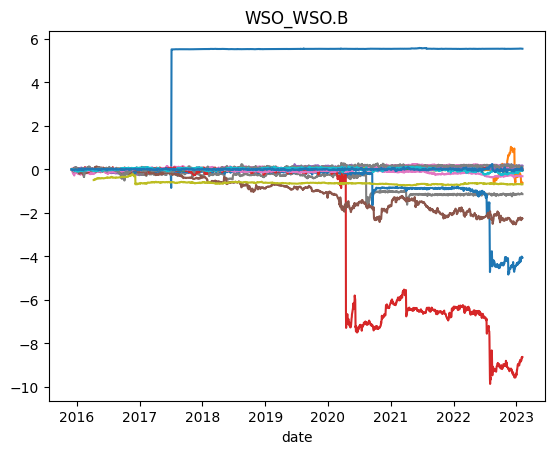

In [6]:
share_class_pairs_pd = pd.DataFrame(mdg.equity_share_class_pairs,columns=['symbol'])
even=share_class_pairs_pd.iloc[::2].copy()
odd=share_class_pairs_pd.iloc[1::2].copy()
pairs_pd = even
pairs_pd['symbol_2']=odd.values
pairs_pd
def get_spread_details(l_pd,s1,s2,to_plot):
    cols=['daily_pct_change']
    l_pd_1=l_pd.query(f'symbol=="{s1}"')[cols].rename(columns={'daily_pct_change':s1})
    l_pd_2=l_pd.query(f'symbol=="{s2}"')[cols].rename(columns={'daily_pct_change':s2})
    pair_md_pd = l_pd_1.join(l_pd_2)
    spread_col = f'spread_{s1}_{s2}'
    pair_md_pd[spread_col]=pair_md_pd[s1]-pair_md_pd[s2]
    if to_plot:
        pair_md_pd[spread_col].cumsum().plot(title=f"{s1}_{s2}")
    return(pair_md_pd)

count=0
for one_pair in pairs_pd.values:
    pair_md_pd=get_spread_details(study_pd,one_pair[0],one_pair[1],False)
    if len(pair_md_pd)>900:
        print(f"{count}:{one_pair[0]}_{one_pair[1]}")
        pair_md_pd[f'spread_{one_pair[0]}_{one_pair[1]}'].cumsum().plot(title=f"{one_pair[0]}_{one_pair[1]}")
    count=count+1


In [7]:
study_pd_no_bench = study_pd.query(f"symbol!='{study_config.get('bench_symbol_market')}' and symbol!='{study_config.get('bench_symbol_local')}'")\
                    .sort_index()
study_pd_bench_market = study_pd.query(f"symbol=='{study_config.get('bench_symbol_market')}'")\
                    .sort_index()
study_pd_bench_local = study_pd.query(f"symbol=='{study_config.get('bench_symbol_local')}'")\
                    .sort_index()
final_cols = ['symbol','date','daily_pct_change','close_last']
study_pd_final=study_pd_no_bench.join(study_pd_bench_market[['symbol','daily_pct_change','close_last']],rsuffix='_bench_market').join(study_pd_bench_local[['symbol','daily_pct_change','close_last']],rsuffix='_bench_local')
study_pd_final['spread_symbol_vs_market']=study_pd_final['daily_pct_change']-study_pd_final['daily_pct_change_bench_market']
study_pd_final['spread_local_vs_market']=study_pd_final['daily_pct_change_bench_local']-study_pd_final['daily_pct_change_bench_market']
study_pd_final=study_pd_final.groupby('symbol').apply(lambda x: x.sort_index().fillna(method='ffill'))
study_pd_final=study_pd_final.drop(columns=['symbol']).reset_index().set_index('date').sort_index()
study_DF_final=spark.createDataFrame(study_pd_final.reset_index())

In [8]:
study_DF_final.show()

+----------+------+----------+----------+---------+-----------+------------+---------+---------+--------+----------+-----------+------------------------------+----------------+-------------------+-----------------------------+-----------------------+------------------+----------------------------+----------------------+-----------------------+----------------------+
|      date|symbol|open_first|high_first|low_first|close_first|minute_first|open_last|high_last|low_last|close_last|minute_last|daily_pct_change_open_to_close|daily_pct_change|symbol_bench_market|daily_pct_change_bench_market|close_last_bench_market|symbol_bench_local|daily_pct_change_bench_local|close_last_bench_local|spread_symbol_vs_market|spread_local_vs_market|
+----------+------+----------+----------+---------+-----------+------------+---------+---------+--------+----------+-----------+------------------------------+----------------+-------------------+-----------------------------+-----------------------+------------

In [9]:
import statsmodels.api as sm

@jit
def one_day_np(l_df):
    if False:
        def get_rmse(y,y_pred):
            return(np.sqrt((np.sum((y_pred-y)**2))/len(y)))
        def get_r2(y,y_pred):
            y_ypred_corr = np.corrcoef(y,y_pred)
            corr=y_ypred_corr[0,1]
            return(corr**2)

        is_last_raw=l_df[:,4]
        is_last=is_last_raw[len(is_last_raw)-1]
        if len(l_df)>1:
            x=l_df[:,0]
            y=l_df[:,1]
            b1=np.corrcoef(x,y)[0][1]*(np.std(y)/np.std(x))
            c=np.mean(y)-b1*np.mean(x)
            y_pred= c+b1*x
            rmse=get_rmse(y,y_pred)
            r2=get_r2(y,y_pred)
            
            ptiles=np.percentile(y_pred-y, [1,5,10,25,75,90,95,99]) 
            p1=ptiles[0]
            p5=ptiles[1]
            p10=ptiles[2]
            p25=ptiles[3]
            p75=ptiles[4]
            p90=ptiles[5]
            p95=ptiles[6]
            p99=ptiles[7]
        else:
            c,b1,rmse,r2,is_last,p1,p5,p10,p25,p75,p90,p95,p99=0,0,0,0,0,0,0,0,0,0,0,0,0
        ret_val=[c,b1,rmse,r2,is_last,p1,p5,p10,p25,p75,p90,p95,p99]
    else:
        ret_val=[1,2,3,4,5,6,7,8,9,10,11,12,13]
    return(ret_val)

def one_day_ols(l_df):
    from statsmodels.tools.eval_measures import rmse
    ret_dict={}
    try:
        Y=np.array(l_df['spread_local_vs_market'].values)
        X=np.array(l_df['spread_symbol_vs_market'].values)
        X = sm.add_constant(X)
        model = sm.OLS(Y,X)
        results = model.fit()
        ret_dict['symbol'] = l_df.symbol.drop_duplicates().values[0]
        ret_dict['r2'] = results.rsquared
        ret_dict['pval_0'] = (results.pvalues[0])
        ret_dict['pval_1'] = (results.pvalues[1])
        ret_dict['const']=(results.params[0])
        ret_dict[f'coeff']=(results.params[1])
        ypred = results.predict(X)
        rmse = rmse(Y, ypred)
        ret_dict['rmse']=rmse
    except Exception as l_e:
        ret_dict['symbol'] = l_df.symbol.drop_duplicates().values[0]
        ret_dict['r2']=0.0
        ret_dict['pval_0']=0.0
        ret_dict['pval_1']=0.0
        ret_dict['const']=0.0
        ret_dict['coeff']=0.0
        ret_dict['rmse']=0.0
        print(l_e)
    return(pd.DataFrame([ret_dict]))
res=(one_day_ols(study_pd_final))
print(res)
@jit
def test(l_df):
    #print((l_df))
    return([0,0,0,0])

  symbol        r2         pval_0         pval_1     const     coeff      rmse
0    ADM  0.001162  4.554696e-207  2.299100e-253  0.000211 -0.006672  0.006857


In [10]:
panda_udf_schema='symbol string,r2 double,pval_0 double,pval_1 double,const double,coeff double,rmse double'
regr_res_pd = study_DF_final.groupby('symbol').applyInPandas(one_day_ols,schema=panda_udf_schema  ).toPandas().set_index('symbol').sort_index()
regr_res_pd

,r2,pval_0,pval_1,const,coeff,rmse
symbol,,,,,,
ADM,0.083628,0.128794,3.634759e-36,0.000235,-0.146693,0.006573
ADP,0.002825,0.172527,2.381757e-02,0.000220,-0.034551,0.006857
ADSK,0.125858,0.347839,9.345924e-55,0.000142,0.132570,0.006420
AEE,0.065901,0.162864,1.334598e-28,0.000218,-0.132484,0.006637
AEP,0.067984,0.193669,1.751743e-29,0.000203,-0.133679,0.006629
...,...,...,...,...,...,...
YUM,0.036023,0.177798,3.992873e-16,0.000214,-0.096567,0.006742
ZBH,0.035062,0.207962,9.942516e-16,0.000200,-0.088763,0.006745
ZBRA,0.033139,0.279786,6.172895e-15,0.000172,0.062523,0.006752


In [11]:
r2=0.2
print(regr_res_pd.query(f'(r2>{r2} and pval_1<0.01) and coeff>0').sort_index())
arkk_like_symbols = regr_res_pd.query(f'r2>{r2} and pval_1<0.01 and coeff>0').index.values
arkk_like_symbols=list(list(arkk_like_symbols)+[study_config.get("bench_symbol_market"),study_config.get("bench_symbol_local")])
arkk_like_pd =study_DF_final.filter(py_f.col('symbol').isin(arkk_like_symbols)).toPandas()
arkk_like_pd=arkk_like_pd.set_index('symbol').join(regr_res_pd)
arkk_like_pd['coeff_sign']=(arkk_like_pd['coeff']>0)*1 + (arkk_like_pd['coeff']<0)*-1

              r2    pval_0         pval_1     const     coeff      rmse
symbol                                                                 
ARKF    0.364434  0.117245  2.579712e-101  0.000261  0.203928  0.005276
ARKK    0.222233  0.236298  1.087881e-100  0.000169  0.173199  0.006056
ARKW    0.272404  0.259007  6.953608e-127  0.000156  0.202266  0.005857
BITQ    0.305335  0.658692   2.210184e-36  0.000109  0.087776  0.005132
COIN    0.275460  0.736181   8.788168e-34 -0.000083  0.060796  0.005227
DAPP    0.298887  0.733929   4.697757e-37  0.000082  0.082661  0.005142
GOOG    0.210573  0.279926   7.649899e-95  0.000155  0.020524  0.006101
IGM     0.657327  0.972969   0.000000e+00 -0.000003  0.831724  0.004020
IGV     0.387974  0.420727  8.543406e-195  0.000102  0.452640  0.005372
PABU    0.201170  0.737150   2.433330e-11 -0.000138  0.847327  0.005801
SKYY    0.323875  0.204895  1.076401e-155  0.000169  0.407862  0.005646
SMH     0.271901  0.765164  1.299486e-126  0.000041  0.301808  0

In [12]:
arkk_like_pd

,date,open_first,high_first,low_first,close_first,minute_first,open_last,high_last,low_last,close_last,...,close_last_bench_local,spread_symbol_vs_market,spread_local_vs_market,r2,pval_0,pval_1,const,coeff,rmse,coeff_sign
symbol,,,,,,,,,,,,,,,,,,,,,
ARKF,2019-02-04,20.16,20.4100,20.1570,20.3552,05:00,20.16,20.4100,20.1570,20.3552,...,169.53,-0.007146,0.005276,0.364434,0.117245,2.579712e-101,0.000261,0.203928,0.005276,1
ARKF,2019-02-05,20.48,20.6100,20.4300,20.5499,05:00,20.48,20.6100,20.4300,20.5499,...,171.03,0.005337,0.004620,0.364434,0.117245,2.579712e-101,0.000261,0.203928,0.005276,1
ARKF,2019-02-06,20.52,20.5336,20.3100,20.4700,05:00,20.52,20.5336,20.3100,20.4700,...,170.52,-0.002680,-0.001774,0.364434,0.117245,2.579712e-101,0.000261,0.203928,0.005276,1
ARKF,2019-02-07,20.29,20.3200,20.0000,20.1700,05:00,20.29,20.3200,20.0000,20.1700,...,168.23,-0.004906,-0.003680,0.364434,0.117245,2.579712e-101,0.000261,0.203928,0.005276,1
ARKF,2019-02-08,20.00,20.2100,19.9500,20.1900,05:00,20.00,20.2100,19.9500,20.1900,...,168.56,-0.000378,0.000592,0.364434,0.117245,2.579712e-101,0.000261,0.203928,0.005276,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XSD,2023-01-31,191.66,196.2000,191.6600,196.1100,05:00,191.66,196.2000,191.6600,196.1100,...,294.62,0.007502,0.000283,0.222462,0.660858,8.326284e-101,0.000063,0.247928,0.006055,1
XSD,2023-02-01,197.07,208.4200,197.0700,206.3600,05:00,197.07,208.4200,197.0700,206.3600,...,300.92,0.041639,0.010756,0.222462,0.660858,8.326284e-101,0.000063,0.247928,0.006055,1
XSD,2023-02-02,208.17,212.5165,206.7600,210.4000,05:00,208.17,212.5165,206.7600,210.4000,...,311.72,0.005020,0.021333,0.222462,0.660858,8.326284e-101,0.000063,0.247928,0.006055,1


In [13]:
arkk_like_pd['is_aligned']=(((arkk_like_pd['daily_pct_change_bench_local']>arkk_like_pd['daily_pct_change_bench_market'])&((arkk_like_pd['daily_pct_change']*arkk_like_pd['coeff_sign'])>=arkk_like_pd['daily_pct_change_bench_local'])) + \
                             ((arkk_like_pd['daily_pct_change_bench_local']<arkk_like_pd['daily_pct_change_bench_market'])&((arkk_like_pd['daily_pct_change']*arkk_like_pd['coeff_sign'])<arkk_like_pd['daily_pct_change_bench_local'])))*(1)
align_stats=arkk_like_pd.groupby(['symbol','is_aligned']).count()[['open_first']].reset_index().pivot_table(values='open_first',columns='is_aligned',index='symbol')
align_stats['total']=align_stats[0]+align_stats[1]
align_stats['aligned']=round(100*(align_stats[1]/align_stats['total']),2)
align_stats['not_aligned']=round(100*(align_stats[0]/align_stats['total']),2)
align_stats

is_aligned,0,1,total,aligned,not_aligned
symbol,,,,,
ARKF,419,591,1010,58.51,41.49
ARKK,740,1068,1808,59.07,40.93
ARKW,717,1091,1808,60.34,39.66
BITQ,162,276,438,63.01,36.99
COIN,164,294,458,64.19,35.81
DAPP,159,299,458,65.28,34.72
GOOG,885,923,1808,51.05,48.95
IGM,858,950,1808,52.54,47.46
IGV,848,960,1808,53.10,46.90


In [32]:
arkk_like_pd['zero']=0
arkk_like_pd=arkk_like_pd.reset_index().set_index('date').sort_index()

<AxesSubplot:xlabel='date'>

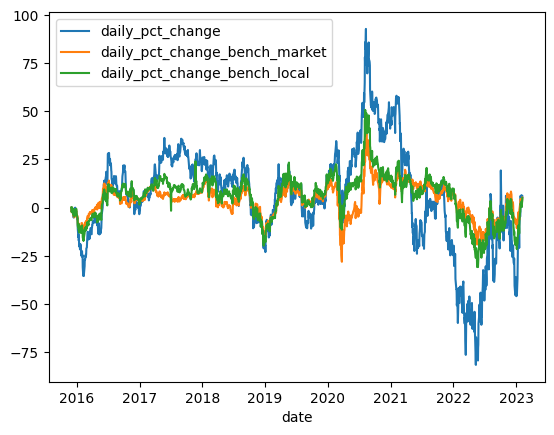

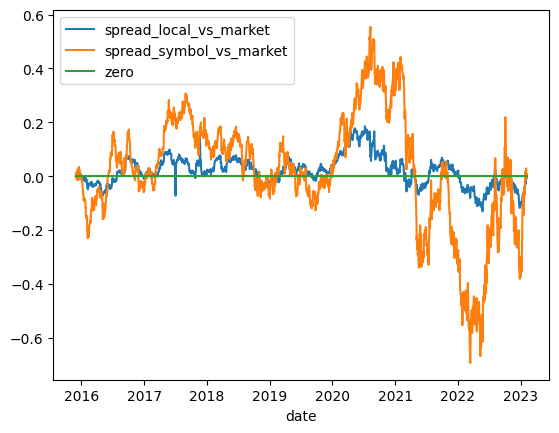

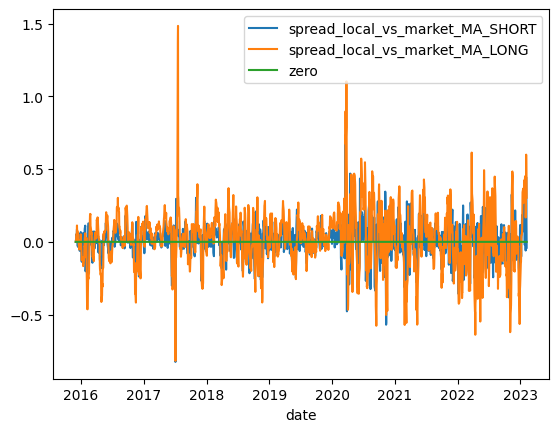

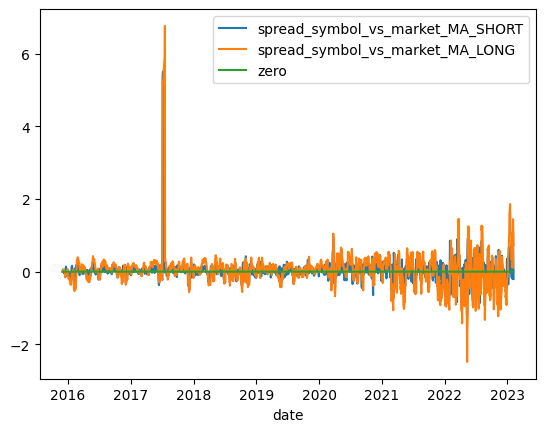

In [41]:
tf=100
tf_sh=int(tf/3)
arkk_like_pd['spread_local_vs_market_MA_LONG']=arkk_like_pd['spread_local_vs_market'].rolling(tf,min_periods=1).sum()
arkk_like_pd['spread_local_vs_market_MA_SHORT']=arkk_like_pd['spread_local_vs_market'].rolling(tf_sh,min_periods=1).sum()
arkk_like_pd['spread_symbol_vs_market_MA_LONG']=arkk_like_pd['spread_symbol_vs_market'].rolling(tf,min_periods=1).sum()
arkk_like_pd['spread_symbol_vs_market_MA_SHORT']=arkk_like_pd['spread_symbol_vs_market'].rolling(tf_sh,min_periods=1).sum()
(arkk_like_pd.query("symbol=='ARKK'")[['daily_pct_change','daily_pct_change_bench_market','daily_pct_change_bench_local']]*100).rolling(tf,min_periods=1).sum().plot()
(arkk_like_pd.query("symbol=='ARKK'")[['spread_local_vs_market','spread_symbol_vs_market','zero']]*1).rolling(tf,min_periods=1).sum().plot()#plot.scatter(x='spread_local_vs_market',y='spread_symbol_vs_market')
(arkk_like_pd.query("symbol=='ARKK'")[['spread_local_vs_market_MA_SHORT','spread_local_vs_market_MA_LONG','zero']]*1).plot()#plot.scatter(x='spread_local_vs_market',y='spread_symbol_vs_market')
(arkk_like_pd.query("symbol=='ARKK'")[['spread_symbol_vs_market_MA_SHORT','spread_symbol_vs_market_MA_LONG','zero']]*1).plot()#plot.scatter(x='spread_local_vs_market',y='spread_symbol_vs_market')

In [60]:
if True:
        spark.createDataFrame(arkk_like_pd.reset_index()).coalesce(1).repartition(1).write\
                        .option("header",True)\
                        .mode("overwrite")\
                        .parquet('s3://fsidatalake/intraday_market_data/align_study_md_close_to_close.parquet')

In [43]:
def get_last_day(l_pd):
    l_pd['prev_date']=l_pd.sort_values('date')['date'].shift(1)
    l_pd['day_delta']=(l_pd.date-l_pd.prev_date).dt.days
    return(l_pd)
arkk_like_pd =arkk_like_pd.reset_index().groupby('symbol').apply(lambda x: get_last_day(x))
arkk_like_pd

,symbol,date,open_first,high_first,low_first,close_first,minute_first,open_last,high_last,low_last,...,r2,pval_0,pval_1,const,coeff,rmse,coeff_sign,is_aligned,prev_date,day_delta
0,ARKF,2019-02-04,20.16,20.4100,20.1570,20.3552,05:00,20.16,20.4100,20.1570,...,0.364434,0.117245,2.579712e-101,0.000261,0.203928,0.005276,1,0,NaN,NaN
1,ARKF,2019-02-05,20.48,20.6100,20.4300,20.5499,05:00,20.48,20.6100,20.4300,...,0.364434,0.117245,2.579712e-101,0.000261,0.203928,0.005276,1,1,2019-02-04,1.0
2,ARKF,2019-02-06,20.52,20.5336,20.3100,20.4700,05:00,20.52,20.5336,20.3100,...,0.364434,0.117245,2.579712e-101,0.000261,0.203928,0.005276,1,1,2019-02-05,1.0
3,ARKF,2019-02-07,20.29,20.3200,20.0000,20.1700,05:00,20.29,20.3200,20.0000,...,0.364434,0.117245,2.579712e-101,0.000261,0.203928,0.005276,1,1,2019-02-06,1.0
4,ARKF,2019-02-08,20.00,20.2100,19.9500,20.1900,05:00,20.00,20.2100,19.9500,...,0.364434,0.117245,2.579712e-101,0.000261,0.203928,0.005276,1,0,2019-02-07,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23615,XSD,2023-01-31,191.66,196.2000,191.6600,196.1100,05:00,191.66,196.2000,191.6600,...,0.222462,0.660858,8.326284e-101,0.000063,0.247928,0.006055,1,1,2023-01-30,1.0
23616,XSD,2023-02-01,197.07,208.4200,197.0700,206.3600,05:00,197.07,208.4200,197.0700,...,0.222462,0.660858,8.326284e-101,0.000063,0.247928,0.006055,1,1,2023-01-31,1.0
23617,XSD,2023-02-02,208.17,212.5165,206.7600,210.4000,05:00,208.17,212.5165,206.7600,...,0.222462,0.660858,8.326284e-101,0.000063,0.247928,0.006055,1,0,2023-02-01,1.0
23618,XSD,2023-02-03,205.39,211.4500,204.5467,206.4200,05:00,205.39,211.4500,204.5467,...,0.222462,0.660858,8.326284e-101,0.000063,0.247928,0.006055,1,1,2023-02-02,1.0


In [47]:
arkk_like_pd=arkk_like_pd.set_index(['symbol','date']).sort_index()

In [59]:
arkk_like_pd.reset_index().groupby(['day_delta','symbol']).agg({'date':'max','const':'count'}).style